In [ ]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, labels = utils.load_features(
    data_dir,
    label_scale=1.1,
    # exclude_sources=["sabre"],
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)
clean_feat_names = feat_df.columns.str.replace(":", ".").to_list()
feat_df.columns = clean_feat_names

print(feat_df.shape)
print(drop_df.shape)
print(labels.shape)

Dropping 0 NaN rows...
(11431, 469)
(11431, 21)
(11431, 1)


In [ ]:
# # TEST PERFORMANCE ON WITHHELD DATA
excluded = "bali3"
excl_idxs = feat_df.query(f"source == '{excluded}'").index.copy()
excl_feats = feat_df.loc[excl_idxs].copy()
excl_labels = labels.loc[excl_idxs].copy()
feat_df = feat_df.drop(excl_idxs, axis=0)
labels = labels.drop(excl_idxs, axis=0)
print(feat_df.shape)
print(drop_df.shape)
print(labels.shape)

(11045, 469)
(11431, 21)
(11045, 1)


In [ ]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))

X_train = feat_df.loc[train_idxs]
X_test = feat_df.loc[test_idxs]
X_valid = feat_df.loc[valid_idxs]
y_train = labels.loc[train_idxs]
y_test = labels.loc[test_idxs]
y_valid = labels.loc[valid_idxs]

8836 1104 1105


In [ ]:
import lightgbm as lgb

param_df = pd.read_parquet(ROOT / "optuna" / "trial_01.parquet")
params = dict(param_df.drop("score", axis=1).iloc[0])
for key, val in params.items():
    if isinstance(params[key], float) and (float(int(val)) == val):
        params[key] = int(val)
# Train the model
model = lgb.LGBMRegressor(**params)
model = model.fit(X_train, y_train)

In [25]:
ref_labels = []
for sub in ["RV11", "RV12"]:
    old_path = Path(f"/hits/fast/cme/bodynems/data/output/balibase3/{sub}")
    ref_df = pd.read_parquet(old_path / "reference_features.parquet")
    id_cols = ["dataset"]
    ref_label = (
        ref_df[id_cols + ["mean_homology_pos_dist"]]
        .groupby("dataset")
        .mean(numeric_only=True)
    )
    ref_labels.append(ref_label)
ref_labels = pd.concat(ref_labels)
ref_labels.columns = ["ref"]
ref_labels = ref_labels.reset_index()
ref_labels["source"] = "bali3"
ref_labels["dataset"] = ref_labels["dataset"].str.rstrip(".msf")

ref_labels.index = pd.MultiIndex.from_arrays(
    [ref_labels["source"], ref_labels["dataset"]]
)
ref_labels = ref_labels.drop(["source", "dataset"], axis=1)

In [26]:
model = model

joint_df = excl_labels.copy()
joint_df = joint_df.loc[ref_labels.index]
joint_df.columns = ["ref_free"]
joint_df["ref_based"] = ref_labels["ref"]
joint_df["predicted"] = model.predict(excl_feats.loc[joint_df.index])
y_pred = joint_df["predicted"]
joint_df.corr()

,ref_free,ref_based,predicted
ref_free,1.000000,0.967487,0.963734
ref_based,0.967487,1.000000,0.947727
predicted,0.963734,0.947727,1.000000


In [27]:
eps = 1e-2
perf_dicts = []
for label in ["ref_based", "ref_free"]:
    y_true = joint_df[label]
    rmse = (((y_pred - y_true) ** 2).sum() / len(y_true)) ** 0.5
    rmse_cv = rmse / np.mean(y_true)
    mae = (np.abs(y_pred - y_true)).sum() / len(y_true)
    mape = (np.abs(y_pred - y_true) / (y_true + eps)).sum() / len(y_true)
    mape_p50 = np.percentile(np.abs(y_pred - y_true) / (y_true + eps), 50)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    perf_dict = {}
    perf_dict["label"] = label
    perf_dict[f"RMSE"] = f"{rmse:.4f}"
    perf_dict[f"RMSE_CV"] = f"{rmse_cv:.4f}"
    perf_dict[f"MAE"] = f"{mae:.4f}"
    perf_dict[f"MAPE"] = f"{mape:.4f}"
    perf_dict[f"MAPE_P50"] = f"{mape_p50:.4f}"
    perf_dict[f"CORR"] = f"{corr:.4f}"
    perf_dicts.append(perf_dict)

perf_df = pd.DataFrame(perf_dicts)
perf_df

,label,RMSE,RMSE_CV,MAE,MAPE,MAPE_P50,CORR
0,ref_based,0.0770,0.2187,0.0578,0.1930,0.1382,0.9477
1,ref_free,0.0600,0.1801,0.0435,0.1504,0.1116,0.9637


['ref_free', 'ref_based', 'predicted']


(0.0, 1.0)

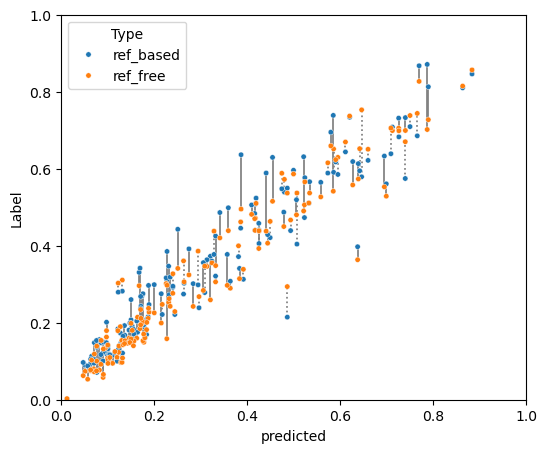

In [81]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(6, 5))
plot_df = pd.melt(
    joint_df,
    id_vars=["predicted"],
    value_vars=["ref_based", "ref_free"],
    var_name="Type",
    value_name="Label",
    # )
    # plot_df.loc[plot_df.Label == "ref_free", "Type"] = (
    #     plot_df.loc[plot_df.Label == "ref_free", "Type"] * 1.1
)
sn.scatterplot(plot_df, x="predicted", y="Label", hue="Type", s=15, ax=ax)

connections = []
print(joint_df.columns.to_list())
dots = list(joint_df.to_numpy())
for ref_free, ref_based, pred in dots:
    connections.append([[pred, ref_based], [pred, ref_free]])
style_mask = np.where(joint_df["ref_based"] < joint_df["ref_free"], ":", "-")
connections = LineCollection(
    connections,
    color="grey",
    zorder=0,
    linestyles=style_mask,
    linewidth=1.25,
)
ax.add_collection(connections)
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.legend()